# European football leagues performance

## Investigation Overview

In this investigation I want to take a deeper look at the european football clubs' performance. My dataset contains the data for the following countries: Belgium, England, France, Germany, Italy, Netherlands, Poland, Portugal, Scotland, Spain and Switzerland.

## Dataset Overview

**dataset consists of 7 dataframes which are:**<br>
1) Country - dataframe with countries included in the dataset<br>
2) League - dataframe with leagues' names for each country included in the 'Country' dataframe<br>
3) Team - dataframe with teams' names<br>
4) Team_Attributes - dataframe with the attributes for each team<br>
5) Match - dataframe with the attributes for each match<br>
6) Player - dataframe with players' names and basic attributes like weight and height<br>
7) Player_Attributes - dataframe with players' football related attributes<br>

In [104]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sb
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row 
from bokeh.plotting import ColumnDataSource, figure, output_file, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Paired
from bokeh.models import ColumnDataSource, NumeralTickFormatter, HoverTool
output_notebook()

Loading BokehJS ...

In [86]:
conn = sqlite3.connect('database.sqlite')

In [87]:
country = pd.read_sql("""SELECT *
                        FROM Country;""", conn)

In [88]:
match = pd.read_sql("""SELECT *
                        FROM Match;""", conn)

In [89]:
team = pd.read_sql("""SELECT *
                        FROM Team;""", conn)

In [90]:
team_attributes = pd.read_sql("""SELECT *
                        FROM Team_Attributes;""", conn)

## Goals distribution
**For all seasons combined (2008/2009 through 2015/2016) distribution of the sum of goals scored in a single match is right skewed with the mode equals 2 goals per match.**

In [91]:
match['sum_of_goals'] = match['home_team_goal'] + match['away_team_goal'] #new column with a sum of goals in a single match
goals_per_match = match['sum_of_goals'].value_counts()
goals_per_match_df = pd.DataFrame(goals_per_match)

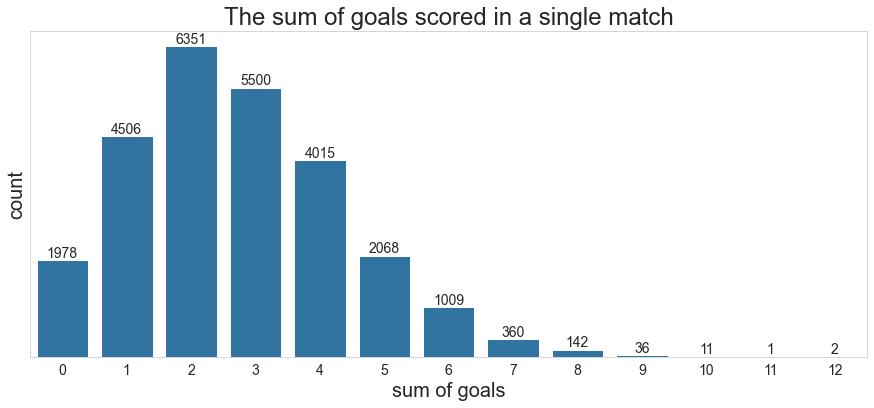

In [92]:
sb.set_style("whitegrid")
colors = sb.color_palette()[0]
plt.figure(figsize = [15, 6])
plt.rcParams.update({'font.size': 14})
ax = sb.barplot(data=goals_per_match_df, x=goals_per_match_df.index, y='sum_of_goals', color=colors)
ax.bar_label(ax.containers[0])
plt.title('The sum of goals scored in a single match', fontsize=24)
plt.xlabel('sum of goals', fontsize=20)
plt.ylabel('count', fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([]);

## Teams' performance in season 2015/2016

**In season 2015/2016:**
- FC Barcelona, Real Madrid (two red dots) and Paris Saint-Germain (green dot) are the only clubs that scored more than 100 goals (bottom right corner of the plot)
- FC Bayern Munich (purple dot), Atletico Madrid (red dot) and Paris Saint-Germain (green dot) are the only clubs that conceded less than 20 goals (three dots at the bottom of the plot)
- ES Troyes (green dot) is the club which conceded the most goals
- Boavista FC (light green dot) is the club that scored the least number of goals

**In general in season 2015/2016 number of goals scored and conceded for particular club have weak (0.3 < r <0.5) negative linear relationship.**.<br>

In [93]:
matches_countries_clubs = match.merge(country, left_on='country_id', right_on='id', how='left').merge(team, left_on='home_team_api_id', right_on='team_api_id')
matches_2015_2016 = matches_countries_clubs[matches_countries_clubs['season']=="2015/2016"]

In [94]:
teams_performance_2015_2016_home = matches_2015_2016.groupby(['home_team_api_id','name','team_long_name']).sum()[['home_team_goal', 'away_team_goal']]
teams_performance_2015_2016_home.reset_index(inplace=True)

In [95]:
teams_performance_2015_2016_away = matches_2015_2016.groupby('away_team_api_id').sum()[['home_team_goal', 'away_team_goal']]
teams_performance_2015_2016_away.reset_index(inplace=True)

In [96]:
teams_performance_2015_2016 = teams_performance_2015_2016_home.merge(teams_performance_2015_2016_away, left_on='home_team_api_id', right_on='away_team_api_id', how='left')
teams_performance_2015_2016['goals_scored'] = teams_performance_2015_2016['home_team_goal_x']+teams_performance_2015_2016['away_team_goal_y']
teams_performance_2015_2016['goals_conceded'] = teams_performance_2015_2016['away_team_goal_x']+teams_performance_2015_2016['home_team_goal_y']
teams_performance_2015_2016.rename(columns={'home_team_api_id':'team_api_id'},inplace=True)
teams_performance_2015_2016 = teams_performance_2015_2016[['team_api_id','name','team_long_name','goals_scored','goals_conceded']]

In [97]:
index_cmap = factor_cmap('name', palette=Paired[11], 
                         factors=teams_performance_2015_2016.name.unique())

p = figure(plot_width=950, plot_height=650, title = "season 2015/2016 - goals scored vs conceded for each club")
p.scatter('goals_scored','goals_conceded',source=teams_performance_2015_2016, fill_alpha=1, fill_color=index_cmap, size=15, legend_field='name')

p.xaxis.axis_label = 'number of goals scored'
p.yaxis.axis_label = 'number of goals conceded'
p.legend.location = "top_right"
p.legend.title = "Countries"
p.legend.label_text_font_size = "16px"
p.title.text_font_size = "20px"
p.xaxis.axis_label_text_font_size = '15pt'
p.yaxis.axis_label_text_font_size = '15pt'

tooltips = [("name", "@name"), ("team_long_name", "@team_long_name"), ("goals_scored","@goals_scored"), ("goals_conceded","@goals_conceded")]
p.add_tools(HoverTool(tooltips=tooltips))

show(p)

## Most important attributes of a team

**In regards to the number of scored and conceded goals both 'defence pressure' and 'defence aggression' seem to be the most important. Both of them have the strongest positive linear relationship with the number of goals scored and the the strongest negative linear relationship with the number of goals conceded.**

In [98]:
list_of_clubs = teams_performance_2015_2016['team_api_id'].tolist()
team_attributes_2015_2016 = team_attributes[team_attributes['date']=='2015-09-10 00:00:00']
team_attributes_2015_2016 = team_attributes_2015_2016[team_attributes_2015_2016['team_api_id'].isin(list_of_clubs)]

In [99]:
teams_performance_2015_2016 = teams_performance_2015_2016.merge(team_attributes_2015_2016, left_on='team_api_id', right_on='team_api_id', how='left')

In [100]:
attributes = ['buildUpPlaySpeed','buildUpPlayDribbling','buildUpPlayPassing','chanceCreationPassing','chanceCreationCrossing','chanceCreationShooting','defencePressure','defenceAggression','defenceTeamWidth']
attributes_goals = attributes + ['goals_scored','goals_conceded']

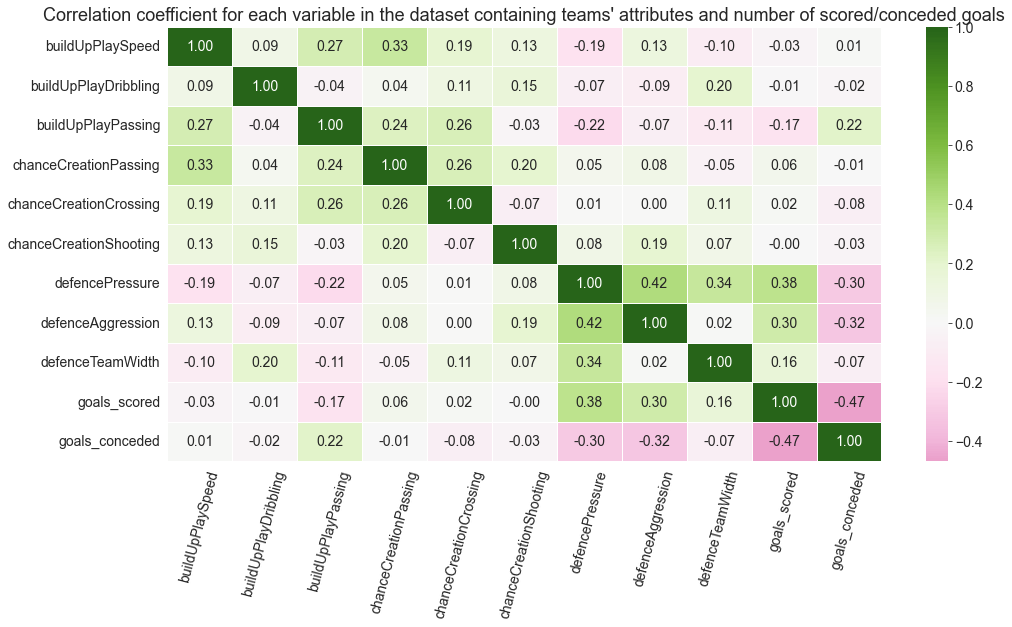

In [101]:
plt.figure(figsize = (16,8))
sb.heatmap(teams_performance_2015_2016[attributes_goals].corr(), cmap="PiYG", center=0, annot=True, fmt='.2f', linewidths=.5)
plt.xticks(rotation=75);
plt.title('Correlation coefficient for each variable in the dataset containing teams\' attributes and number of scored/conceded goals',fontsize=18);